root
 |-- NUM_POSTE: decimal(8,0) (nullable = true)
 |-- NOM_USUEL: string (nullable = true)
 |-- LAT: double (nullable = true)
 |-- LON: double (nullable = true)
 |-- ALTI: integer (nullable = true)
 |-- AAAAMMJJ: integer (nullable = true)
 |-- RR: double (nullable = true)
 |-- QRR: integer (nullable = true)
 |-- TN: double (nullable = true)
 |-- QTN: integer (nullable = true)
 |-- HTN: integer (nullable = true)
 |-- QHTN: integer (nullable = true)
 |-- TX: double (nullable = true)
 |-- QTX: integer (nullable = true)
 |-- HTX: integer (nullable = true)
 |-- QHTX: integer (nullable = true)
 |-- TM: double (nullable = true)
 |-- QTM: integer (nullable = true)
 |-- TNTXM: double (nullable = true)
 |-- QTNTXM: integer (nullable = true)
 |-- TAMPLI: double (nullable = true)
 |-- QTAMPLI: integer (nullable = true)
 |-- TNSOL: double (nullable = true)
 |-- QTNSOL: integer (nullable = true)
 |-- TN50: double (nullable = true)
 |-- QTN50: integer (nullable = true)
 |-- DG: integer (nullable = 

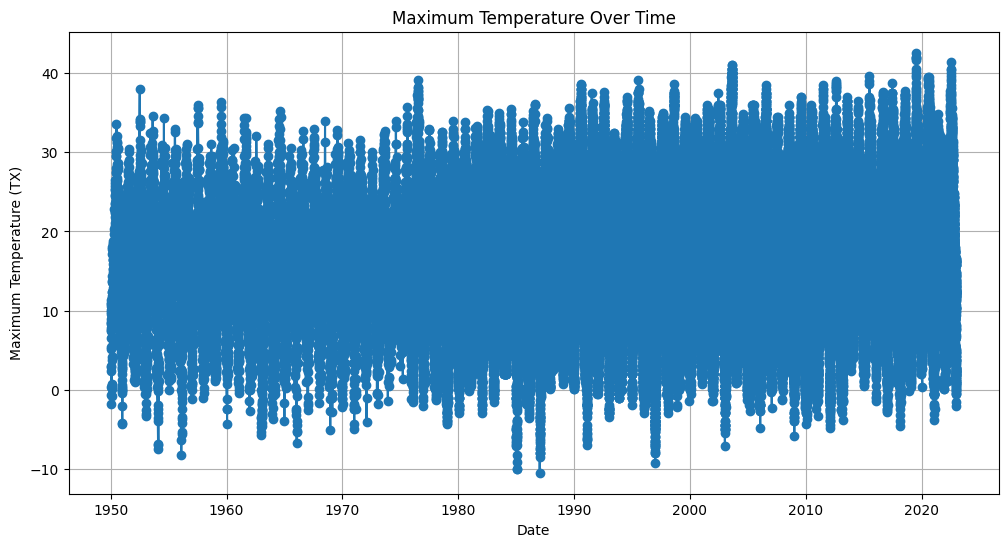

In [3]:
from pyspark.sql import SparkSession
import pandas as pd
import matplotlib.pyplot as plt
import os

# Initialize Spark session
spark = SparkSession.builder \
    .appName("Partitioned Data Plotting") \
    .getOrCreate()

# Path to the directory containing the partitioned CSV files
data_dir = "./all_weather"  # Adjust this path as needed

# Read all partitioned CSV files into a single DataFrame
df = spark.read.csv(os.path.join(data_dir, "part-*"), header=True, inferSchema=True)

# Show the schema and a sample of the DataFrame
df.printSchema()
df.show(5)

# Convert to Pandas DataFrame for plotting
pandas_df = df.toPandas()

# Convert the date column to a datetime format
pandas_df['AAAAMMJJ'] = pd.to_datetime(pandas_df['AAAAMMJJ'], format='%Y%m%d')

# Plotting temperature over time
plt.figure(figsize=(12, 6))
plt.plot(pandas_df['AAAAMMJJ'], pandas_df['TX'], marker='o', linestyle='-')
plt.title("Maximum Temperature Over Time")
plt.xlabel("Date")
plt.ylabel("Maximum Temperature (TX)")
plt.grid(True)
plt.show()

# Close the Spark session
spark.stop()


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Chargement des datasets
weather_df = pd.read_csv('path/to/2023-2024-weather_cleaned.csv')
traffic_df = pd.read_csv('path/to/2013-2021_trafic.csv')
validations_df = pd.read_csv('path/to/validations-reseau-ferre-nombre-validations-par-jour-1er-semestre.csv')
chantier_df = pd.read_csv('path/to/chantier2019-2022.csv')

# 2. Prétraitement des données

# Renommer les colonnes pour simplifier les jointures
weather_df.rename(columns={'NUM_POSTE': 'station_id', 'AAAAMMJJ': 'date'}, inplace=True)
traffic_df.rename(columns={'Station': 'station_name', 'Trafic': 'traffic'}, inplace=True)
validations_df.rename(columns={'CODE_STIF_ARRET': 'station_id', 'JOUR': 'date'}, inplace=True)
chantier_df.rename(columns={'Date début du chantier': 'start_date', 'Date fin du chantier': 'end_date'}, inplace=True)

# Convertir les dates en format datetime
weather_df['date'] = pd.to_datetime(weather_df['date'], format='%Y%m%d')
validations_df['date'] = pd.to_datetime(validations_df['date'], format='%Y-%m-%d')
chantier_df['start_date'] = pd.to_datetime(chantier_df['start_date'])
chantier_df['end_date'] = pd.to_datetime(chantier_df['end_date'])

# Fusionner les datasets sur les stations et les dates
merged_df = pd.merge(weather_df, validations_df, on=['station_id', 'date'], how='left')
merged_df = pd.merge(merged_df, traffic_df, left_on='station_id', right_on='Station', how='left')

# Créer une colonne binaire pour indiquer si un chantier a lieu sur une station à une date donnée
def is_chantier(row, chantier_df):
    for _, chantier in chantier_df.iterrows():
        if chantier['start_date'] <= row['date'] <= chantier['end_date']:
            return 1
    return 0

merged_df['chantier'] = merged_df.apply(lambda row: is_chantier(row, chantier_df), axis=1)

# 3. Séparation des données en ensembles d'entraînement et de test
X = merged_df.drop(columns=['chantier', 'date', 'station_name'])
y = merged_df['chantier']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Création et entraînement du modèle
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 5. Évaluation du modèle
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# 6. Visualisation des résultats
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
feature_importances.nlargest(10).plot(kind='barh')
plt.show()

# Heatmap des corrélations
corr_matrix = merged_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()


ModuleNotFoundError: No module named 'sklearn'

In [1]:
import pandas as pd
import json
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Chargement des datasets
print("Chargement des datasets...")
weather_df = pd.read_csv('./all_weather/2023-2024-weather_cleaned.csv')
traffic_df = pd.read_csv('./freq_arret/2013-2021_trafic.csv')
validations_df = pd.read_csv('./freq_arret/validations-reseau-ferre-nombre-validations-par-jour-1er-semestre.csv', sep=';')
chantier_df = pd.read_csv('chantier2019-2022.csv')
print("Datasets chargés.")

# Chargement du JSON des voies ferrées
print("Chargement du JSON des voies ferrées...")
with open(r'C:\Users\SKONIECZNY\Desktop\Transport_App\client\src\common\traces-du-reseau-ferre-idf.json', 'r') as file:
    voie_data = json.load(file)
print("JSON des voies ferrées chargé.")

# Extraire les informations du JSON des voies ferrées
print("Extraction des informations du JSON des voies ferrées...")
voies_list = []
for feature in voie_data['features']:
    properties = feature['properties']
    coordinates = feature['geometry']['coordinates']
    voie = {
        'idrefliga': properties['idrefliga'],
        'reseau': properties['reseau'],
        'mode': properties['mode'],
        'coordinates': coordinates
    }
    voies_list.append(voie)
voies_df = pd.DataFrame(voies_list)
print("Informations des voies ferrées extraites.")

# 2. Prétraitement des données
print("Prétraitement des données...")

# Renommer les colonnes pour simplifier les jointures
print("Renommage des colonnes...")
weather_df.rename(columns={'NUM_POSTE': 'station_id', 'AAAAMMJJ': 'date'}, inplace=True)
traffic_df.rename(columns={'Station': 'station_name', 'Trafic': 'traffic'}, inplace=True)
validations_df.rename(columns={'CODE_STIF_ARRET': 'station_id', 'JOUR': 'date'}, inplace=True)
chantier_df.rename(columns={'Date début du chantier': 'start_date', 'Date fin du chantier': 'end_date'}, inplace=True)
print("Colonnes renommées.")

# Vérifier les colonnes
print("Colonnes de weather_df:", weather_df.columns)
print("Colonnes de traffic_df:", traffic_df.columns)
print("Colonnes de validations_df:", validations_df.columns)
print("Colonnes de chantier_df:", chantier_df.columns)

# Convertir 'station_id' en string pour les deux dataframes avant la fusion
print("Conversion des types de données...")
weather_df['station_id'] = weather_df['station_id'].astype(str)
validations_df['station_id'] = validations_df['station_id'].astype(str)

# Convertir les dates en format datetime
weather_df['date'] = pd.to_datetime(weather_df['date'], format='%Y%m%d')
validations_df['date'] = pd.to_datetime(validations_df['date'], format='%Y-%m-%d')
chantier_df['start_date'] = pd.to_datetime(chantier_df['start_date'])
chantier_df['end_date'] = pd.to_datetime(chantier_df['end_date'])
print("Types de données convertis.")

# Fusionner les datasets sur les stations et les dates
print("Fusion des datasets...")
merged_df = pd.merge(weather_df, validations_df, on=['station_id', 'date'], how='left')
merged_df = pd.merge(merged_df, traffic_df, left_on='station_id', right_on='station_name', how='left')
print("Datasets fusionnés.")

# Joindre les données de voies
print("Ajout des informations des voies...")
def match_voie(station_id, voies_df):
    for _, voie in voies_df.iterrows():
        if station_id in voie['coordinates']:
            return voie['reseau'], voie['mode']
    return None, None

merged_df[['reseau', 'mode']] = merged_df['station_id'].apply(lambda x: match_voie(x, voies_df)).apply(pd.Series)
print("Informations des voies ajoutées.")

# Créer une colonne binaire pour indiquer si un chantier a lieu sur une station à une date donnée
print("Création de la colonne 'chantier'...")
def is_chantier(row, chantier_df):
    for _, chantier in chantier_df.iterrows():
        if chantier['start_date'] <= row['date'] <= chantier['end_date']:
            return 1
    return 0

merged_df['chantier'] = merged_df.apply(lambda row: is_chantier(row, chantier_df), axis=1)
print("Colonne 'chantier' créée.")

# 3. Séparation des données en ensembles d'entraînement et de test
print("Séparation des données en ensembles d'entraînement et de test...")
columns_to_drop = ['chantier', 'date', 'station_name']
if 'coordinates' in merged_df.columns:
    columns_to_drop.append('coordinates')

X = merged_df.drop(columns=columns_to_drop)
y = merged_df['chantier']

# Sélection des colonnes numériques et catégorielles
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Pipeline pour les colonnes numériques
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Pipeline pour les colonnes catégorielles
categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combiner les transformations dans un ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Pipeline complet avec prétraitement et modèle
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Données séparées.")

# 4. Création et entraînement du modèle
print("Création et entraînement du modèle...")
model.fit(X_train, y_train)
print("Modèle créé et entraîné.")

# 5. Évaluation du modèle
print("Évaluation du modèle...")
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Évaluation du modèle terminée.")

# 6. Visualisation des résultats
print("Visualisation des résultats...")
# Extraire l'importance des features
importances = model.named_steps['classifier'].feature_importances_

# Récupérer les noms des features après OneHotEncoding
encoder = model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['encoder']
encoded_cat_features = encoder.get_feature_names_out(categorical_features)

# Combiner les noms des features
feature_names = np.hstack([numeric_features, encoded_cat_features])

# Visualiser l'importance des features
feature_importances = pd.Series(importances, index=feature_names)
feature_importances.nlargest(10).plot(kind='barh')
plt.show()

# Heatmap des corrélations
print("Visualisation des corrélations...")
corr_matrix = merged_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

# Exemple de retour des coordonnées et de la probabilité pour une voie donnée
print("Exemple de prédiction avec probabilité pour une voie donnée...")
example_station_id = merged_df.iloc[0]['station_id']
example_row = merged_df[merged_df['station_id'] == example_station_id].drop(columns=columns_to_drop + ['chantier']).iloc[0]
example_prediction = model.predict([example_row])[0]
example_proba = model.predict_proba([example_row])[0]

print(f"Station ID: {example_station_id}")
print(f"Coordonnées: {merged_df[merged_df['station_id'] == example_station_id]['coordinates'].values[0]}")
print(f"Prédiction: {'Chantier' if example_prediction == 1 else 'Pas de chantier'}")
print(f"Probabilités: {example_proba}")


ModuleNotFoundError: No module named 'sklearn'

In [4]:
!pip install pandas
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn
!pip install numpy


     ---------------------------------------- 0.0/60.6 kB ? eta -:--:--
     ---------------------------------------- 60.6/60.6 kB 3.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/10.6 MB ? eta -:--:--
   -------- ------------------------------- 2.2/10.6 MB 46.2 MB/s eta 0:00:01
   ------------------- -------------------- 5.0/10.6 MB 53.5 MB/s eta 0:00:01
   ----------------------------- ---------- 7.8/10.6 MB 55.2 MB/s eta 0:00:01
   ---------------------------------------  10.6/10.6 MB 59.5 MB/s eta 0:00:01
   ---------------------------------------  10.6/10.6 MB 59.5 MB/s eta 0:00:01
   ---------------------------------------- 10.6/10.6 MB 46.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/301.8 kB ? eta -:--:--
   --------------------------------------- 301.8/301.8 kB 18.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/46.2 MB ? eta -:--:--
   -- ------------------------------------- 2.9/46.2 MB 60.8 MB/s eta 0:00:01
   ---- 

In [11]:
import pandas as pd
import json
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Function to convert dates with different formats
def parse_dates(date_str):
    try:
        return pd.to_datetime(date_str, format='%d/%m/%Y', errors='raise')
    except ValueError:
        try:
            return pd.to_datetime(date_str, format='%Y-%m-%d', errors='raise')
        except ValueError:
            if isinstance(date_str, str) and 'S' in date_str:
                year = int(date_str[:4])
                semester = int(date_str[-1])
                month = 1 if semester == 1 else 7
                return pd.Timestamp(year=year, month=month, day=1)
            else:
                return pd.NaT

# Function to load JSON data
def load_json(file_path):
    with open(file_path, 'r') as file:
        return json.load(file)

# Function to read large CSV files in smaller chunks
def read_csv_in_chunks(file_path, chunk_size=10000):
    reader = pd.read_csv(file_path, dtype={'1': str, '2': str, '4': str}, chunksize=chunk_size, on_bad_lines='skip')
    chunks = []
    for chunk in reader:
        chunks.append(chunk)
    return pd.concat(chunks, ignore_index=True)

# Function to load all CSV files from a directory
def load_all_csv_from_dir(directory, chunk_size=10000):
    all_data = []
    for file in os.listdir(directory):
        if file.endswith('.csv'):
            print(f"Loading {file}...")
            try:
                data = read_csv_in_chunks(os.path.join(directory, file), chunk_size=chunk_size)
                all_data.append(data)
            except Exception as e:
                print(f"Error loading {file}: {e}")
    return pd.concat(all_data, ignore_index=True)

# Load datasets
print("Loading datasets...")
weather_df = pd.read_csv('./all_weather/2023-2024-weather_cleaned.csv')
traffic_df = pd.read_csv('./freq_arret/2013-2021_trafic.csv')
validations_df = pd.read_csv('./freq_arret/validations-reseau-ferre-nombre-validations-par-jour-1er-semestre.csv', sep=';')
chantier_df = pd.read_csv('chantier2019-2022.csv')

print("Chargement du JSON des voies ferrées...")
with open(r'C:\Users\SKONIECZNY\Desktop\Transport_App\client\src\common\traces-du-reseau-ferre-idf.json', 'r') as file:
    voie_data = json.load(file)
print("JSON des voies ferrées chargé.")

# Extraire les informations du JSON des voies ferrées
print("Extraction des informations du JSON des voies ferrées...")
voies_list = []
for feature in voie_data['features']:
    properties = feature['properties']
    coordinates = feature['geometry']['coordinates']
    voie = {
        'idrefliga': properties['idrefliga'],
        'reseau': properties['reseau'],
        'mode': properties['mode'],
        'coordinates': coordinates
    }
    voies_list.append(voie)
voies_df = pd.DataFrame(voies_list)
print("Informations des voies ferrées extraites.")

# Load additional CSV files from directories
print("Loading additional datasets...")
merged_nb_fer_df = load_all_csv_from_dir('./validation/merged_NB_FER.csv/')
merged_profil_df = load_all_csv_from_dir('./validation/merged_PROFIL.csv/')

# Load JSON files for line reports
print("Loading line report JSON data...")
line_report_files = [f'./line-report/{file}' for file in os.listdir('./line-report') if file.endswith('.json')]
line_reports = [load_json(file) for file in line_report_files]

# Load additional CSV files
print("Loading specific additional CSV files...")
additional_csv_files = [
    './freq_arret/arrets.csv',
    './freq_arret/validations-reseau-ferre-nombre-validations-par-jour-1er-semestre.csv',
    './freq_arret/validations-reseau-ferre-profils-horaires-par-jour-type-1er-semestre.csv',
    './indicateurs-qualite-service-sncf-ratp.csv',
    './TravauxSNCF_RATP_2019-2022.csv',
]

additional_dfs = [read_csv_in_chunks(file) for file in additional_csv_files]

# Combine all additional CSV dataframes
additional_df = pd.concat(additional_dfs, ignore_index=True)

print("Datasets loaded.")

# Preprocess data
print("Preprocessing data...")

# Rename columns for easier merging
print("Renaming columns...")
weather_df.rename(columns={'NUM_POSTE': 'station_id', 'AAAAMMJJ': 'date'}, inplace=True)
traffic_df.rename(columns={'Station': 'station_name', 'Trafic': 'traffic'}, inplace=True)
validations_df.rename(columns={'CODE_STIF_ARRET': 'station_id', 'JOUR': 'date'}, inplace=True)
chantier_df.rename(columns={'Date début du chantier': 'start_date', 'Date fin du chantier': 'end_date'}, inplace=True)
print("Columns renamed.")

# Convert 'station_id' to string for the two dataframes before merging
print("Converting data types...")
weather_df['station_id'] = weather_df['station_id'].astype(str)
validations_df['station_id'] = validations_df['station_id'].astype(str)
merged_nb_fer_df['station_id'] = merged_nb_fer_df['CODE_STIF_ARRET'].astype(str)
merged_profil_df['station_id'] = merged_profil_df['CODE_STIF_ARRET'].astype(str)

# Convert dates to datetime format
weather_df['date'] = pd.to_datetime(weather_df['date'], format='%Y%m%d')
validations_df['date'] = pd.to_datetime(validations_df['date'], format='%Y-%m-%d')
chantier_df['start_date'] = pd.to_datetime(chantier_df['start_date'])
chantier_df['end_date'] = pd.to_datetime(chantier_df['end_date'])
merged_nb_fer_df['date'] = merged_nb_fer_df['date'].apply(parse_dates)
merged_profil_df['date'] = merged_profil_df['date'].apply(parse_dates)
print("Data types converted.")

# Merge datasets on stations and dates
print("Merging datasets...")
merged_df = pd.merge(weather_df, validations_df, on=['station_id', 'date'], how='left')
merged_df = pd.merge(merged_df, traffic_df, left_on='station_id', right_on='station_name', how='left')
merged_df = pd.merge(merged_df, merged_nb_fer_df, on=['station_id', 'date'], how='left')
merged_df = pd.merge(merged_df, merged_profil_df, on=['station_id', 'date'], how='left')




Loading datasets...
Chargement du JSON des voies ferrées...
JSON des voies ferrées chargé.
Extraction des informations du JSON des voies ferrées...
Informations des voies ferrées extraites.
Loading additional datasets...
Loading part-00000-4bea7afa-2c52-475e-b6d2-caee215c049a-c000.csv...
Loading part-00001-4bea7afa-2c52-475e-b6d2-caee215c049a-c000.csv...
Loading part-00002-4bea7afa-2c52-475e-b6d2-caee215c049a-c000.csv...
Loading part-00003-4bea7afa-2c52-475e-b6d2-caee215c049a-c000.csv...
Loading part-00004-4bea7afa-2c52-475e-b6d2-caee215c049a-c000.csv...
Loading part-00005-4bea7afa-2c52-475e-b6d2-caee215c049a-c000.csv...
Loading part-00006-4bea7afa-2c52-475e-b6d2-caee215c049a-c000.csv...
Loading part-00007-4bea7afa-2c52-475e-b6d2-caee215c049a-c000.csv...
Loading part-00008-4bea7afa-2c52-475e-b6d2-caee215c049a-c000.csv...
Loading part-00009-4bea7afa-2c52-475e-b6d2-caee215c049a-c000.csv...
Loading part-00010-4bea7afa-2c52-475e-b6d2-caee215c049a-c000.csv...
Loading part-00011-4bea7afa-2c5

In [ ]:
# Ensure chantier_df is merged to include 'start_date' and 'end_date'
print("Merging chantier information...")
chantier_df['start_date'] = pd.to_datetime(chantier_df['start_date'])
chantier_df['end_date'] = pd.to_datetime(chantier_df['end_date'])
chantier_df['Code postal arrondissement - Commune'] = chantier_df['Code postal arrondissement - Commune'].astype(str)
chantier_df['start_date'] = pd.to_datetime(chantier_df['start_date'], format='%Y-%m-%d')
chantier_df['end_date'] = pd.to_datetime(chantier_df['end_date'], format='%Y-%m-%d')

merged_df['Code postal arrondissement - Commune'] = merged_df['station_id'].apply(lambda x: x[:5])
merged_df = pd.merge(merged_df, chantier_df, left_on='Code postal arrondissement - Commune', right_on='Code postal arrondissement - Commune', how='left')

# Join line reports (process disruptions to include them in the merged dataframe)
def get_disruption_info(station_id, line_reports):
    for report in line_reports:
        for disruption in report.get('disruptions', []):
            for obj in disruption.get('impacted_objects', []):
                if obj['pt_object']['id'] == station_id:
                    return disruption['category'], disruption['severity']['effect']
    return None, None

print("Adding line report information...")
merged_df[['disruption_category', 'disruption_effect']] = merged_df['station_id'].apply(lambda x: get_disruption_info(x, line_reports)).apply(pd.Series)

# Join voie information
print("Adding voie information...")
def match_voie(station_id, voies_df):
    for _, voie in voies_df.iterrows():
        for coord in voie['coordinates']:
            if station_id in coord:
                return voie['reseau'], voie['mode']
    return None, None

merged_df[['reseau', 'mode']] = merged_df['station_id'].apply(lambda x: match_voie(x, voies_df)).apply(pd.Series)

# Create a binary column to indicate a problem
print("Creating 'probleme' column...")
def has_probleme(row):
    if (pd.notnull(row['start_date']) and pd.notnull(row['end_date']) and row['start_date'] <= row['date'] <= row['end_date']) or row['NEIG'] > 0 or row['RR'] > 20 or row['traffic'] > 200000 or row['NB_VALD'] > 1500:
        return 1
    return 0

merged_df['probleme'] = merged_df.apply(has_probleme, axis=1)
print("Colonne 'probleme' créée.")

# 3. Split data into training and testing sets
print("Splitting data into training and testing sets...")
columns_to_drop = merged_df.columns.drop('probleme')

X = merged_df.drop(columns=columns_to_drop)
y = merged_df['probleme']

# Select numeric and categorical features
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Pipeline for categorical features
categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformations in a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Complete pipeline with preprocessing and model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Data split.")

# 4. Train the model
print("Training the model...")
model.fit(X_train, y_train)
print("Model trained.")

# 5. Evaluate the model
print("Evaluating the model...")
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Model evaluation complete.")

# 6. Visualize results
print("Visualizing results...")
# Extract feature importances
importances = model.named_steps['classifier'].feature_importances_

# Get feature names after OneHotEncoding
encoder = model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['encoder']
encoded_cat_features = encoder.get_feature_names_out(categorical_features)

# Combine feature names
feature_names = np.hstack([numeric_features, encoded_cat_features])

# Visualize feature importances
feature_importances = pd.Series(importances, index=feature_names)
feature_importances.nlargest(10).plot(kind='barh')
plt.show()

# Heatmap of correlations
print("Visualizing correlations...")
corr_matrix = merged_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

# Example of returning coordinates and probability for a given station
print("Example prediction with probability for a given station...")
example_station_id = merged_df.iloc[0]['station_id']
example_row = merged_df[merged_df['station_id'] == example_station_id].drop(columns=columns_to_drop + ['probleme']).iloc[0]
example_prediction = model.predict([example_row])[0]
example_proba = model.predict_proba([example_row])[0]

print(f"Station ID: {example_station_id}")
print(f"Coordinates: {merged_df[merged_df['station_id'] == example_station_id]['coordinates'].values[0] if 'coordinates' in merged_df.columns else 'N/A'}")
print(f"Prediction: {'Probleme' if example_prediction == 1 else 'No Probleme'}")
print(f"Probabilities: {example_proba}")